In [1]:
import pickle as pkl
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from vla_calibration.utils import *
from vla_calibration.calibration import *

plt.style.use('seaborn-v0_8')
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def run_experiment(
        task_name, 
        quant=None,
        alternate_set=1, 
        n_prompts=20, 
        n_cal_bins=12,
):
    
    data_save_dir = f"../results/libero_{task_name}"
    if quant is not None:
        data_save_dir += f"/{quant}"

    top_n_steps=1

    base_probs, _, correct = get_base_data(data_save_dir, top_n_steps)

    base_probs = np.expand_dims(base_probs, axis=2)

    all_probs = []

    for i in range(n_prompts):

        prompt_probs = []

        if alternate_set == 1:
            data_save_str = f"{data_save_dir}/episode_data_prompt_{i}.pkl"
        elif alternate_set == 2:
            data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v2.pkl"
        elif alternate_set == 3:
            data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v3.pkl"
        else:
            raise ValueError

        with open(data_save_str, "rb") as f:  
            data = pkl.load(f)

        for episode in data:

            episode_probs = []

            steps = episode["steps"]

            for step in steps[:top_n_steps]:

                logits = step["logits"]
                probs = softmax(logits, -1)

                episode_probs.append(probs)

            episode_probs = np.stack(episode_probs)
            prompt_probs.append(episode_probs)

        prompt_probs = np.stack(prompt_probs)

        all_probs.append(prompt_probs)

    
    all_probs = np.stack(all_probs)
    ens_probs = np.transpose(all_probs, (1,2,0,3,4))

    base_probs = base_probs[:,0]
    ens_probs = ens_probs[:,0]


    base_probs = np.max(base_probs, -1)
    ens_probs = np.max(ens_probs, -1)

    base_conf = np.mean(base_probs, -2)
    ens_conf = np.mean(ens_probs, -2)

    mean_base_conf = np.mean(base_conf, -1)
    mean_ens_conf = np.mean(ens_conf, -1)

    base_ece1 = round(get_ece(mean_base_conf, correct, n_cal_bins, p=1), 3)
    ens_ece1 = round(get_ece(mean_ens_conf, correct, n_cal_bins, p=1), 3)

    base_ece2 = round(get_ece(mean_base_conf, correct, n_cal_bins, p=2), 3)
    ens_ece2 = round(get_ece(mean_ens_conf, correct, n_cal_bins, p=2), 3)

    base_brier = round(np.mean((mean_base_conf - correct)**2), 3)
    ens_brier = round(np.mean((mean_ens_conf - correct)**2), 3)

    base_ce = cross_entropy(correct, mean_base_conf)
    ens_ce = cross_entropy(correct, mean_ens_conf)

    if quant is not None:
        quant_tag = quant
    else:
        quant_tag = "Full"

    base_row = [task_name, quant_tag, "baseline", base_ece1, base_ece2, base_brier, base_ce, np.mean(correct)]
    ens_row = [task_name, quant_tag, "reprompt", ens_ece1, ens_ece2, ens_brier, ens_ce, np.mean(correct)]
    rows = [base_row, ens_row]

    df = pd.DataFrame(rows, columns=["Dataset","Model","Method","ECE-1","ECE-2","Brier","NLL","Accuracy"])
    return df
    


In [3]:
n_bins = 12
alternate_set = 1

full_df = pd.DataFrame()

In [4]:
df = run_experiment(
    "spatial", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    n_prompts=20
)
full_df = pd.concat([full_df, df])

df = run_experiment(
    "object", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    n_prompts=20
)
full_df = pd.concat([full_df, df])

df = run_experiment(
    "goal", 
    alternate_set=alternate_set,  
    n_cal_bins=n_bins,
    n_prompts=20
)
full_df = pd.concat([full_df, df])


In [5]:
full_df

,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758


In [6]:
df = run_experiment(
    "spatial", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    quant="quant8",
    n_prompts=20
)
full_df = pd.concat([full_df, df])

df = run_experiment(
    "object", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    quant="quant8",
    n_prompts=20
)
full_df = pd.concat([full_df, df])

df = run_experiment(
    "goal", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    quant="quant8",
    n_prompts=20
)
full_df = pd.concat([full_df, df])

In [7]:
full_df

,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758
0,spatial,quant8,baseline,0.070,0.093,0.138,0.487558,0.844
1,spatial,quant8,reprompt,0.050,0.062,0.131,0.434179,0.844
0,object,quant8,baseline,0.057,0.065,0.110,0.408945,0.876
1,object,quant8,reprompt,0.041,0.052,0.108,0.374542,0.876


In [8]:
df = run_experiment(
    "spatial", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    quant="quant4",
    n_prompts=20
)
full_df = pd.concat([full_df, df])

df = run_experiment(
    "object", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    quant="quant4",
    n_prompts=20
)
full_df = pd.concat([full_df, df])

df = run_experiment(
    "goal", 
    alternate_set=alternate_set, 
    n_cal_bins=n_bins,
    quant="quant4",
    n_prompts=20
)
full_df = pd.concat([full_df, df])

In [9]:
full_df

,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758
0,spatial,quant8,baseline,0.070,0.093,0.138,0.487558,0.844
1,spatial,quant8,reprompt,0.050,0.062,0.131,0.434179,0.844
0,object,quant8,baseline,0.057,0.065,0.110,0.408945,0.876
1,object,quant8,reprompt,0.041,0.052,0.108,0.374542,0.876


In [10]:
main_df = full_df[["Model", "Dataset", "Method", "ECE-1", "ECE-2", "Brier", "NLL"]]
main_df = main_df[main_df["Model"] != "quant4"]
display(main_df)

,Model,Dataset,Method,ECE-1,ECE-2,Brier,NLL
0,Full,spatial,baseline,0.088,0.106,0.150,0.533038
1,Full,spatial,reprompt,0.052,0.068,0.145,0.476606
0,Full,object,baseline,0.060,0.073,0.108,0.401004
1,Full,object,reprompt,0.036,0.053,0.105,0.360989
0,Full,goal,baseline,0.151,0.170,0.207,0.707188
1,Full,goal,reprompt,0.115,0.132,0.197,0.619534
0,quant8,spatial,baseline,0.070,0.093,0.138,0.487558
1,quant8,spatial,reprompt,0.050,0.062,0.131,0.434179
0,quant8,object,baseline,0.057,0.065,0.110,0.408945
1,quant8,object,reprompt,0.041,0.052,0.108,0.374542


In [11]:
print(main_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrr}
\toprule
Model & Dataset & Method & ECE-1 & ECE-2 & Brier & NLL \\
\midrule
Full & spatial & baseline & 0.088 & 0.106 & 0.150 & 0.533 \\
Full & spatial & reprompt & 0.052 & 0.068 & 0.145 & 0.477 \\
Full & object & baseline & 0.060 & 0.073 & 0.108 & 0.401 \\
Full & object & reprompt & 0.036 & 0.053 & 0.105 & 0.361 \\
Full & goal & baseline & 0.151 & 0.170 & 0.207 & 0.707 \\
Full & goal & reprompt & 0.115 & 0.132 & 0.197 & 0.620 \\
quant8 & spatial & baseline & 0.070 & 0.093 & 0.138 & 0.488 \\
quant8 & spatial & reprompt & 0.050 & 0.062 & 0.131 & 0.434 \\
quant8 & object & baseline & 0.057 & 0.065 & 0.110 & 0.409 \\
quant8 & object & reprompt & 0.041 & 0.052 & 0.108 & 0.375 \\
quant8 & goal & baseline & 0.140 & 0.163 & 0.205 & 0.713 \\
quant8 & goal & reprompt & 0.117 & 0.152 & 0.194 & 0.608 \\
\bottomrule
\end{tabular}



In [12]:
app_df = full_df[["Model", "Dataset", "Method", "ECE-1", "ECE-2", "Brier", "NLL"]]
app_df = app_df[app_df["Model"] == "quant4"]
display(app_df)

,Model,Dataset,Method,ECE-1,ECE-2,Brier,NLL
0,quant4,spatial,baseline,0.067,0.086,0.149,0.502941
1,quant4,spatial,reprompt,0.055,0.079,0.148,0.482491
0,quant4,object,baseline,0.091,0.112,0.135,0.488945
1,quant4,object,reprompt,0.066,0.094,0.132,0.454047
0,quant4,goal,baseline,0.161,0.182,0.231,0.747501
1,quant4,goal,reprompt,0.146,0.154,0.224,0.672038


In [13]:
print(app_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lllrrrr}
\toprule
Model & Dataset & Method & ECE-1 & ECE-2 & Brier & NLL \\
\midrule
quant4 & spatial & baseline & 0.067 & 0.086 & 0.149 & 0.503 \\
quant4 & spatial & reprompt & 0.055 & 0.079 & 0.148 & 0.482 \\
quant4 & object & baseline & 0.091 & 0.112 & 0.135 & 0.489 \\
quant4 & object & reprompt & 0.066 & 0.094 & 0.132 & 0.454 \\
quant4 & goal & baseline & 0.161 & 0.182 & 0.231 & 0.748 \\
quant4 & goal & reprompt & 0.146 & 0.154 & 0.224 & 0.672 \\
\bottomrule
\end{tabular}



In [14]:
tradeoff_df = full_df[full_df["Method"] == "reprompt"]
display(tradeoff_df)

metrics_list = ["ECE-1", "ECE-2", "Brier", "NLL"]

,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758
1,spatial,quant8,reprompt,0.050,0.062,0.131,0.434179,0.844
1,object,quant8,reprompt,0.041,0.052,0.108,0.374542,0.876
1,goal,quant8,reprompt,0.117,0.152,0.194,0.608067,0.760
1,spatial,quant4,reprompt,0.055,0.079,0.148,0.482491,0.822
1,object,quant4,reprompt,0.066,0.094,0.132,0.454047,0.850
1,goal,quant4,reprompt,0.146,0.154,0.224,0.672038,0.712


In [15]:
success_df = tradeoff_df[["Dataset", "Model", "Accuracy"]]
display(success_df)

row1 = ["Full"] + success_df[success_df["Model"] == "Full"]["Accuracy"].tolist()
row2 = ["Quant-8"] + success_df[success_df["Model"] == "quant8"]["Accuracy"].tolist()
row3 = ["Quant-4"] + success_df[success_df["Model"] == "quant4"]["Accuracy"].tolist()

success_df = pd.DataFrame([row1, row2, row3], columns=["Model", "Spatial", "Object", "Goal"])
print(success_df.to_latex(index=False, float_format="%.3f"))

,Dataset,Model,Accuracy
1,spatial,Full,0.828
1,object,Full,0.880
1,goal,Full,0.758
1,spatial,quant8,0.844
1,object,quant8,0.876
1,goal,quant8,0.760
1,spatial,quant4,0.822
1,object,quant4,0.850
1,goal,quant4,0.712


\begin{tabular}{lrrr}
\toprule
Model & Spatial & Object & Goal \\
\midrule
Full & 0.828 & 0.880 & 0.758 \\
Quant-8 & 0.844 & 0.876 & 0.760 \\
Quant-4 & 0.822 & 0.850 & 0.712 \\
\bottomrule
\end{tabular}



In [16]:
baseline_df = full_df[full_df["Method"] == "baseline"]

In [17]:
reprompt_df = full_df[full_df["Method"] == "reprompt"]

In [18]:
baseline_df

,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758
0,spatial,quant8,baseline,0.070,0.093,0.138,0.487558,0.844
0,object,quant8,baseline,0.057,0.065,0.110,0.408945,0.876
0,goal,quant8,baseline,0.140,0.163,0.205,0.713381,0.760
0,spatial,quant4,baseline,0.067,0.086,0.149,0.502941,0.822
0,object,quant4,baseline,0.091,0.112,0.135,0.488945,0.850
0,goal,quant4,baseline,0.161,0.182,0.231,0.747501,0.712


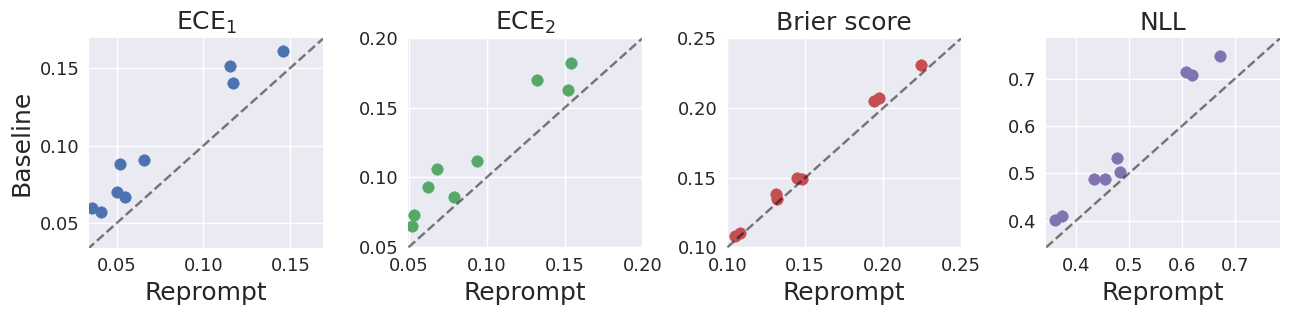

In [19]:
fig, axs = plt.subplots(1,4, figsize=(13,3.25))

for i, metric in enumerate(metrics_list):

    coord = i
    ax = axs[coord]

    baseline_scores = baseline_df[metric].tolist()
    reprompt_scores = reprompt_df[metric].tolist()
    ax.scatter(reprompt_scores, baseline_scores, color=pal[i], s=70)
    ax.plot([0,1],[0,1], "--", color="k", alpha=0.5)

    ax_min = min(min(baseline_scores),min(reprompt_scores))*0.95
    ax_max = max(max(baseline_scores),max(reprompt_scores))*1.05

    ax.set_xlim(ax_min, ax_max)
    ax.set_ylim(ax_min, ax_max)

    ax.set_title(metric, fontsize=18)
    ax.set_xlabel("Reprompt", fontsize=18)
    
    if i == 0:
        ax.set_ylabel("Baseline", fontsize=18)
        
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    # ticks = ax.get_xticks()
    # ax.set_yticks(ticks)

axs[0].set_xticks([0.05, 0.10,0.15])
axs[0].set_yticks([0.05, 0.10,0.15])

axs[1].set_xticks([0.05, 0.10,0.15,0.2])
axs[1].set_yticks([0.05, 0.10,0.15,0.2])

axs[2].set_xticks([0.1, 0.15, 0.2,0.25])
axs[2].set_yticks([0.1, 0.15, 0.2,0.25])

axs[3].set_xticks([0.40, 0.50, 0.60, 0.70])
axs[3].set_yticks([0.40, 0.50, 0.60, 0.70])

for i in range(4):
    axs[i].tick_params(axis='x', labelsize=13)
    axs[i].tick_params(axis='y', labelsize=13)

axs[0].set_title(r"$\text{ECE}_1$", fontsize=18)
axs[1].set_title(r"$\text{ECE}_2$", fontsize=18)
axs[2].set_title("Brier score", fontsize=18)
    
fig.tight_layout()
plt.savefig("../plots/total_results.png", dpi=600, bbox_inches="tight")
plt.show()


[0.59090909 0.6        0.7615894  0.71428571 0.71929825 0.83571429
 0.82089552 0.72527473 0.9068323 ]
[0.64150943 0.7260274  0.77647059 0.66666667 0.8        0.93251534
 0.91860465 0.83928571 0.84615385]
[0.96666667 0.97222222 0.95169082 0.94927536 0.98181818 0.94634146
 0.99328859 0.97777778 0.96969697]
[0.89413129 0.90021202 0.87605262 0.89051763 0.91587558 0.85237418
 0.95933972 0.9286253  0.89904715]


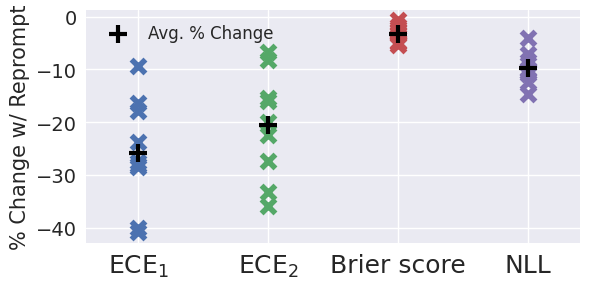

In [20]:
fig = plt.figure(figsize=(6,3))

for i, metric in enumerate(metrics_list):

    bm = np.array(baseline_df[metric].tolist())
    rm = np.array(reprompt_df[metric].tolist())

    print(rm/bm)

    plt.scatter([i/2]*len(bm), -(1-(rm/bm))*100, marker="x", s=100, lw=4)
    if i == 0:
        plt.scatter([i/2], -(1-(np.mean(rm/bm)))*100, marker="+", color="k", label="Avg. % Change", s=150, lw=3)
    else:
        plt.scatter([i/2], -(1-(np.mean(rm/bm)))*100, marker="+", color="k", s=150, lw=3)


xticks = [r"$\text{ECE}_1$",r"$\text{ECE}_2$","Brier score","NLL"]
plt.xticks(np.arange(4)/2, xticks, fontsize=18)
plt.ylabel("% Change w/ Reprompt", fontsize=15)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc="upper left")

plt.xlim(-0.2,1.7)

fig.tight_layout()

plt.savefig("../plots/pct_reduction.png", dpi=600, bbox_inches="tight")
plt.show()


,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy
0,spatial,Full,baseline,0.088,0.106,0.150,0.533038,0.828
0,object,Full,baseline,0.060,0.073,0.108,0.401004,0.880
0,goal,Full,baseline,0.151,0.170,0.207,0.707188,0.758
0,spatial,quant8,baseline,0.070,0.093,0.138,0.487558,0.844
0,object,quant8,baseline,0.057,0.065,0.110,0.408945,0.876
0,goal,quant8,baseline,0.140,0.163,0.205,0.713381,0.760
0,spatial,quant4,baseline,0.067,0.086,0.149,0.502941,0.822
0,object,quant4,baseline,0.091,0.112,0.135,0.488945,0.850
0,goal,quant4,baseline,0.161,0.182,0.231,0.747501,0.712


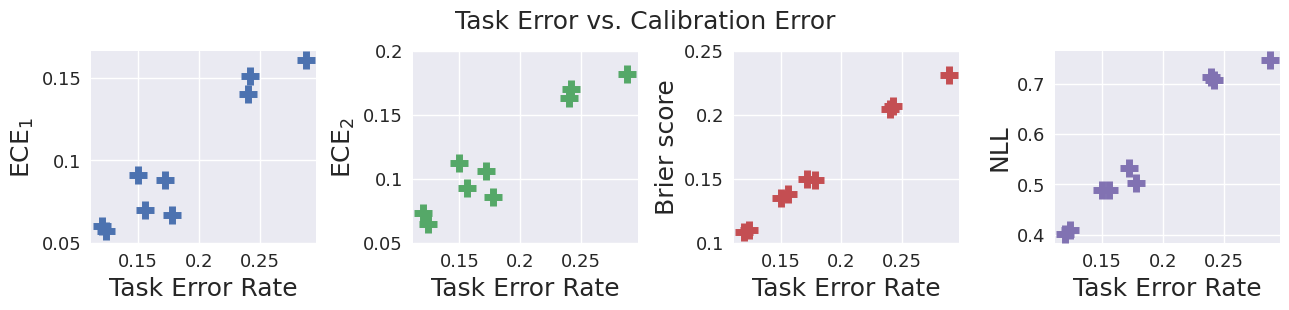

In [21]:
tradeoff_df = full_df[full_df["Method"] == "baseline"]
display(tradeoff_df)

metrics_list = ["ECE-1", "ECE-2", "Brier", "NLL"]

fig, axs = plt.subplots(
    1,4, 
    figsize=(13,3.25), 
    # sharex=True
)

for i, metric in enumerate(metrics_list):

    coord = i
    ax = axs[coord]

    for model in ["Full", "quant8", "quant4"]:

        sub_df = tradeoff_df[tradeoff_df["Model"] == model]
        axs[coord].scatter(1-np.array(sub_df["Accuracy"]), sub_df[metric], marker="+", label=model, s=150, lw=5, color=pal[i])

for i in range(4):
    axs[i].set_xlabel("Task Error Rate", fontsize=18)
    axs[i].set_xticks([0.15, 0.2, 0.25], [0.15, 0.2, 0.25], fontsize=13)
# axs[1,0].set_xlabel("Task Error", fontsize=14)
# axs[1,1].set_xlabel("Task Error", fontsize=14)

axs[0].set_ylabel(r"$\text{ECE}_1$", fontsize=18)
axs[1].set_ylabel(r"$\text{ECE}_2$", fontsize=18)
axs[2].set_ylabel(r"Brier score", fontsize=18)
axs[3].set_ylabel(r"NLL", fontsize=18)


axs[0].set_yticks([0.05, 0.10,0.15], [0.05, 0.10,0.15], fontsize=13)
axs[1].set_yticks([0.05, 0.10,0.15,0.2], [0.05, 0.10,0.15,0.2], fontsize=13)
axs[2].set_yticks([0.1, 0.15, 0.2,0.25], [0.1, 0.15, 0.2,0.25], fontsize=13)
axs[3].set_yticks([0.40, 0.50, 0.60, 0.70], [0.40, 0.50, 0.60, 0.70], fontsize=13)

fig.suptitle("Task Error vs. Calibration Error", y=0.94, fontsize=18)

plt.tight_layout()
plt.savefig("../plots/tradeoffs_baseline.png", dpi=600, bbox_inches="tight")
plt.show()

,Dataset,Model,Method,ECE-1,ECE-2,Brier,NLL,Accuracy
1,spatial,Full,reprompt,0.052,0.068,0.145,0.476606,0.828
1,object,Full,reprompt,0.036,0.053,0.105,0.360989,0.880
1,goal,Full,reprompt,0.115,0.132,0.197,0.619534,0.758
1,spatial,quant8,reprompt,0.050,0.062,0.131,0.434179,0.844
1,object,quant8,reprompt,0.041,0.052,0.108,0.374542,0.876
1,goal,quant8,reprompt,0.117,0.152,0.194,0.608067,0.760
1,spatial,quant4,reprompt,0.055,0.079,0.148,0.482491,0.822
1,object,quant4,reprompt,0.066,0.094,0.132,0.454047,0.850
1,goal,quant4,reprompt,0.146,0.154,0.224,0.672038,0.712


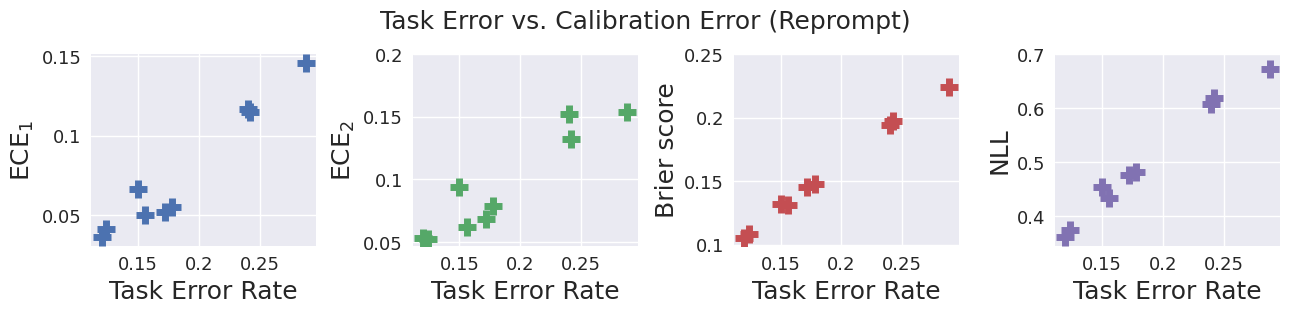

In [23]:
tradeoff_df = full_df[full_df["Method"] == "reprompt"]
display(tradeoff_df)

metrics_list = ["ECE-1", "ECE-2", "Brier", "NLL"]

fig, axs = plt.subplots(
    1,4, 
    figsize=(13,3.25), 
    # sharex=True
)

for i, metric in enumerate(metrics_list):

    coord = i
    ax = axs[coord]

    for model in ["Full", "quant8", "quant4"]:

        sub_df = tradeoff_df[tradeoff_df["Model"] == model]
        axs[coord].scatter(1-np.array(sub_df["Accuracy"]), sub_df[metric], marker="+", label=model, s=150, lw=5, color=pal[i])

for i in range(4):
    axs[i].set_xlabel("Task Error Rate", fontsize=18)
    axs[i].set_xticks([0.15, 0.2, 0.25], [0.15, 0.2, 0.25], fontsize=13)


axs[0].set_ylabel(r"$\text{ECE}_1$", fontsize=18)
axs[1].set_ylabel(r"$\text{ECE}_2$", fontsize=18)
axs[2].set_ylabel(r"Brier score", fontsize=18)
axs[3].set_ylabel(r"NLL", fontsize=18)


axs[0].set_yticks([0.05, 0.10,0.15], [0.05, 0.10,0.15], fontsize=13)
axs[1].set_yticks([0.05, 0.10,0.15,0.2], [0.05, 0.10,0.15,0.2], fontsize=13)
axs[2].set_yticks([0.1, 0.15, 0.2,0.25], [0.1, 0.15, 0.2,0.25], fontsize=13)
axs[3].set_yticks([0.40, 0.50, 0.60, 0.70], [0.40, 0.50, 0.60, 0.70], fontsize=13)

fig.suptitle("Task Error vs. Calibration Error (Reprompt)", y=0.95, fontsize=18)

plt.tight_layout()
plt.savefig("../plots/tradeoffs_reprompt.png", dpi=600, bbox_inches="tight")
plt.show()